# Parameterizing MD correlation functions

## Setup

In [1]:
# Make sure pyDR is installed and on the path
import sys
import os
if 'google.colab' in sys.modules: #Colab
    !git clone https://github.com/alsinmr/pyDR
else:
    os.chdir('../../..')

In [2]:
# imports
import pyDR
from pyDR.Fitting.fit import model_free
from pyDR.MDtools import vft
from pyDR.misc.tools import linear_ex
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from time import time

In [3]:
# Download the trajectory files
xtc='https://drive.google.com/file/d/1wq5T-YDmPo2zAIWu9we2zyL2i-v52fnD/view?usp=sharing'
pdb='https://drive.google.com/file/d/1aBMUO2C1AZfx05dANl4QITHuqmHbDDsN/view?usp=sharing'

if not(os.path.exists('ubi.pdb')):
    pyDR.IO.download(pdb,'ubi.pdb')
if not(os.path.exists('ubi.xtc')):
    pyDR.IO.download(xtc,'ubi.xtc')

In [4]:
def align(uni,fileout='ubi_aligned.xtc',ref_sel='name CA'):
    """
    This function takes a trajectory and aligns it based on
    a reference selection of atoms. The new trajectory is
    returned in fileout (default is ubi_aligned.xtc)
    """
    
    from scipy.linalg import svd
    
    uni.trajectory[0] #Go to the first frame of the trajectory
    atoms=uni.atoms   #All atoms in the trajectory
    ref_sel=uni.select_atoms(ref_sel)  #Atom group for the reference
    
    ref0=ref_sel.positions #initial positions of reference atoms
    ref0-=ref0.mean(0) #Centers the initial position
    
    with mda.Writer(fileout,atoms.n_atoms) as W:
        for ts in uni.trajectory:
            ref=ref_sel.positions
            pos=atoms.positions

            pos-=ref.mean(0)   #This centers the reference
            ref-=ref.mean(0)   
            
            H=ref0.T@ref       #3x3 matrix
            U,S,Vt=svd(H)      #Singular value decomposition
            V=Vt.T             #Transposes
            Ut=U.T

            R=V@Ut             #Rotation matrix for alignment
            
            pos_corr=(R.T@pos.T).T
            atoms.positions=pos_corr
            
            W.write(atoms)
    return

In [5]:
uni0=mda.Universe('ubi.pdb','ubi.xtc')
if not(os.path.exists('ubi_aligned.xtc')):
    align(uni0,fileout='ubi_aligned.xtc')   #Runs the code to align Ubiquitin in the universe
uni=mda.Universe('ubi.pdb','ubi_aligned.xtc')  #Loads the aligned trajectory

In [6]:
proj=pyDR.Project()
proj.append_data('https://raw.githubusercontent.com/alsinmr/pyDR_tutorial/main/data/ubi_soln.txt')

sel=pyDR.MolSelect(topo='ubi.pdb',traj_files='ubi_aligned.xtc',project=proj)
sel.select_bond('15N')
pyDR.md2data(sel)


Loading Ref. Frames: |██████████████████████████████████████████████████| 100.0% Complete
Completed
r:MD:ubi_aligned with 72 data points


In [7]:
proj['MD']['raw'].detect.r_no_opt(12)
proj['MD']['raw'].fit()

Fitted 1 data objects
pyDIFRATE project with 1 data sets

Titles:
n12:MD:ubi_aligned


In [8]:
class MFfit():
        def __init__(self,z,A,error,fit,npars):
            self.npars=npars
            self.z=np.array(z)
            self.A=np.array(A)
            self.error=error
            self.fit=fit
        
        @property
        def S2(self):
            return 1-np.array([A0 for A0 in self.A]).sum(0)
        
        @property
        def tc(self):
            return 10**self.z
        
        def calc_rates(self,sens):
            out=[linear_ex(sens.z,sens.rhoz,z0)*A0 for z0,A0 in zip(self.z,self.A)]
            out=np.array(out).sum(0)
            if hasattr(sens,'R0'):
                out=(out.T+sens.R0).T
            return out
        
        def compare_rates(self,data):
            data.plot(style='p')
            rates=self.calc_rates(data.sens)
            for k,(R,a) in enumerate(zip(rates,data.project.plot_obj.ax)):
                a.scatter(self.fit.label,R,color='black',s=10)
                a.set_ylabel(f'{data.info[k]["Type"]} ({data.info[k]["v0"]})')
                
            return data.project.plot_obj
        
        def plot_fit(self,index=np.linspace(0,72,9).astype(int)):
            n=len(index)
            ax,*_=pyDR.Plotting.subplot_setup(n)
            
            Ct=proj['raw']['MD'][0]
            t=Ct.info['t']
            print(np)
            
            ct=np.array([A0*np.exp(-(t/1e-9)/tc0) for A0,tc0 in zip(self.A,self.tc)]).sum(0)
            ct+=1-self.A[k].sum()
            
            for k,a in enumerate(ax):
                a.plot(t,Ct.R[index[k]],color='red')
                
                
                a.plot(t,Ct,color='black',linestyle=':')
                
            return ax

def MF(npars):
    if len(proj[f'p{npars}:MD:ubi_aligned'])==0:
        data=proj['MD']['no_opt'][0]
        data.detect.r_auto(npars)
        fit=data.fit()
    else:
        fit=proj[f'p{npars}:MD:ubi_aligned'][0]   
    nz=np.ceil(npars/2).astype(int)
    fixz=[-14.,*[None for _ in range(nz-1)]] if np.mod(npars,2) else None
    print(fixz)
    z,A,error,fit=model_free(fit,nz=nz,fixz=fixz)
    return MFfit(z,A,error,fit,npars)
    
def Detectors(npars):
    if len(proj[f'p{npars}:MD:ubi_aligned'])==0:
        data=proj['MD']['no_opt'][0]
        data.detect.r_auto(npars)
        fit=data.fit()
        

In [18]:
t=proj['raw']['MD'].info['t']
ct=np.array([A0*np.exp(-np.kron((t/1e-9),1/tc0)) for A0,tc0 in zip(mf.A,mf.tc)]).sum(0)
ct+=1-self.A[k].sum(0)

TypeError: loop of ufunc does not support argument 0 of type float which has no callable exp method

In [19]:
tc0=mf.tc[0]
A0=mf.A[0]

In [9]:
mf=MF(5)

[-14.0, None, None]
1 of 16 iterations
2 of 16 iterations


/Users/albertsmith/Documents/GitHub.nosync/pyDR/Fitting/fit.py:398: RuntimeWarning: invalid value encountered in reciprocal
  pinv=((m**2).sum(1)**(-1))*m.T


3 of 16 iterations
4 of 16 iterations
5 of 16 iterations
6 of 16 iterations
7 of 16 iterations
8 of 16 iterations
9 of 16 iterations
10 of 16 iterations
11 of 16 iterations
12 of 16 iterations
13 of 16 iterations
14 of 16 iterations
15 of 16 iterations
16 of 16 iterations


Text(0, 0.5, 'R1')

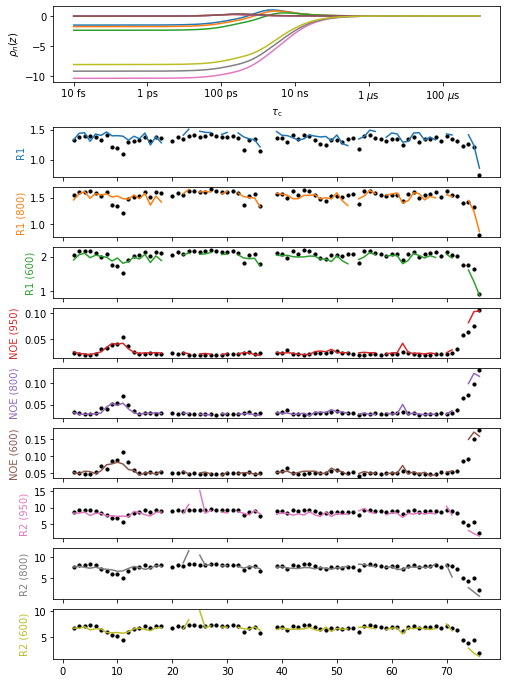

In [10]:
proj.close_fig('all')
mf.__class__=MFfit
mf.compare_rates(proj[0])
proj.fig.set_size_inches([8,12])
proj.plot_obj.ax[0].set_ylabel('R1')

In [14]:
mf.tc.shape

(3, 72)

<module 'numpy' from '/opt/anaconda3/lib/python3.8/site-packages/numpy/__init__.py'>


TypeError: loop of ufunc does not support argument 0 of type float which has no callable exp method

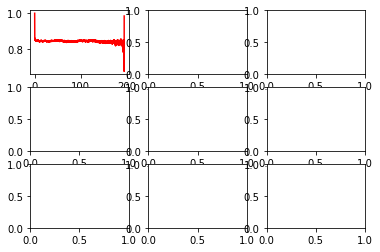

In [11]:
mf.__class__=MFfit
mf.plot_fit()

In [72]:
proj.current=1

In [74]:
proj.plot_obj.fig

AttributeError: 'NoneType' object has no attribute 'fig'